# Applying Time Series Regression to Ocean Gauge Data

Christopher Liu 

Contact: cmhl@uw.edu

Last change - Takes in pre-generated test and train splits 2/6

Previous changes
* 1/24 added extra verification tests
* 1/10 Created module for most functions
* 1/7 Threshold target pred gauge, can use different sklearn models now
* 12/19 Redid comparison plots
* 10/8/2020, Added classifcation problem
* 9/30/2020, added mag and lat, plots to compare different size windows
* 9/18/2020, added scaling for the feature dataframes

-----
[tsfresh](https://tsfresh.readthedocs.io/) is required to run this notebook

----
To do:
* Remove runs_used
* document module
* doublecheck tsr.predict
* results for non-filtered seem to be terrible?

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tsunami_regress as tsr
import os
import importlib

from scipy.interpolate import interp1d

from pylab import *
from IPython.display import Image

np.set_printoptions(threshold=1000) # edit as needed

In [106]:
importlib.reload(tsr) # remove after done testing

<module 'tsunami_regress' from 'C:\\Users\\Chris\\Dropbox\\Tsunami Research\\tsunami_regress.py'>

## Plots

Plots of the original uninterpolated data. Time series, slip on fault and surface deformation. Only contains runs 600-699

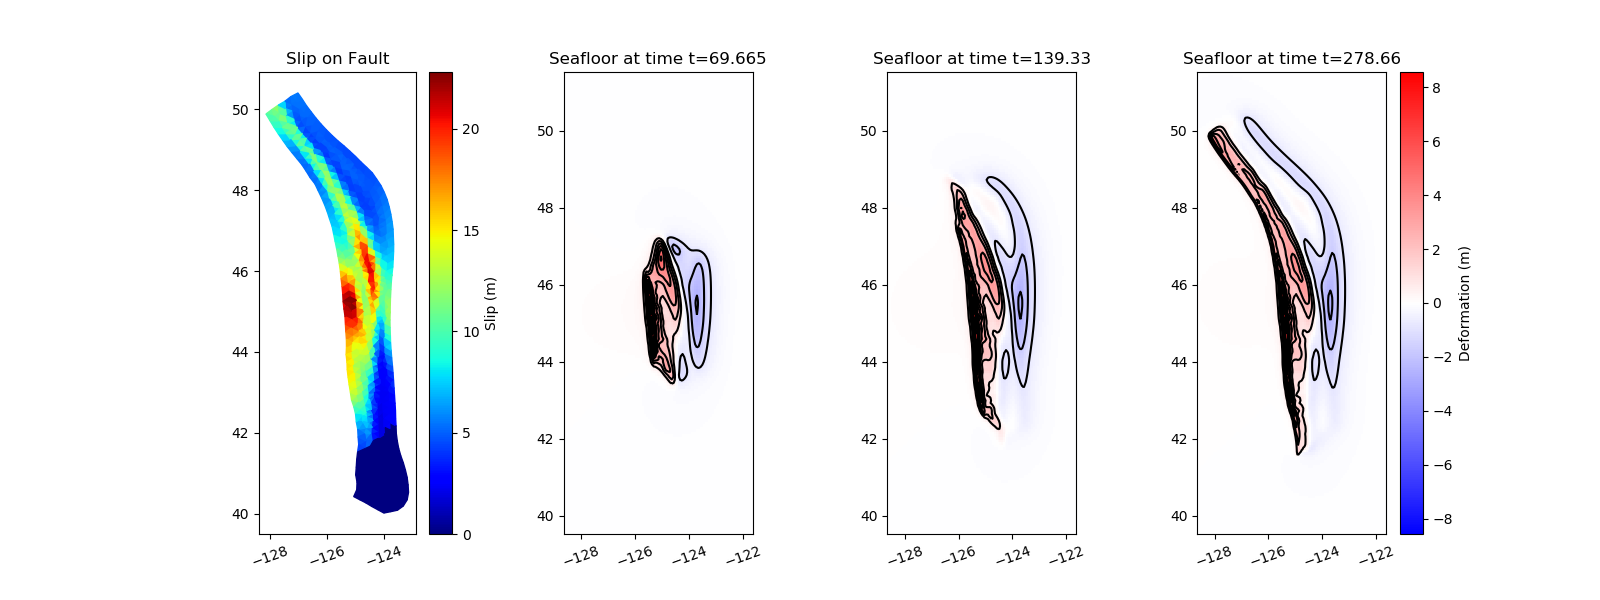

In [4]:
rnum = 1297   # run number
dtopo_png = 'C:/Users/Chris/Desktop/Tsunami Personal/SJDF_files/dtopo/cascadia%s.png' % str(rnum).zfill(6)
Image(dtopo_png, width=900)

In [5]:
# (Un)comment as needed

# rnums = range(608,609)
# etamax = {}

# figure(figsize=(12,6))
# for rnum in rnums:
#     outdir = 'C:/Users/Chris/Desktop/SJDF_files/gauges/run_%s/_output' % str(rnum).zfill(6)
#     #print('outdir = ', outdir)

#     gaugenos = [702]
#     for gaugeno in gaugenos:
#         gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
#         gdata = loadtxt(gfile)
#         t = gdata[:,1] / 60.  # minutes
#         eta = gdata[:,5]  # surface elevation in meters
#         plot(t, eta, label='Run # %s' % rnum)
#         etamax[(rnum,gaugeno)] = eta.max()

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters) and scaled momenutm')
# grid(True)
# legend()

# Load Data

Loads the interpolated time series data. This step can be skipped if loading the features/data frame directly

In [6]:
runs = range(0,1300)
gauges = [702,901,911]
ddir = 'C:/Users/Chris/Desktop/Tsunami Personal/gauge_data'

eta, t= tsr.load_data(ddir, runs, gauges)

In [ ]:
# Code for plotting some of the data. (Un)comment as needed

# gnum = 901
# rnum = 564

# plot(t[(rnum,gnum)]/60,eta[(rnum,gnum)])

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters)')
# grid(True)

# Featurize

In [8]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from tsfresh import extract_features, select_features
from tsfresh.feature_selection import relevance
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, settings

In [9]:
# Load txt file containing the run numbers used
path = r'C:\Users\Chris\Documents\Tsunami\jdf-autoencoder\python'
runnos = np.loadtxt(os.path.join(path,'data\sjdf_runno.txt')).astype(int)

In [10]:
tsteps = [181, 361] # 30 minutes
threshold = 0.1
sub_thresh = -2000 # set to arbitrarily large negative number if you do not want to filter for subsidence
sub_time = 31

eta_g702 = []
run_id = []
runs_used = []
times = []
tstart = []

for i in range(len(tsteps)):
    eta_tmp, run_id_tmp, runs_used_tmp, times_tmp, tstart_tmp =\
        tsr.stack_series(eta, t, 702, runnos, 901, 0.5, threshold, tsteps[i], sub_thresh, sub_time)
#     eta_tmp, runs_used_tmp, times_tmp, tstart_tmp =\
#         tsr.stack_series_raw(eta, t, 702, runnos, 901, 0.5, threshold, tsteps[i], sub_thresh, sub_time)
    
    eta_g702.append(eta_tmp)
    run_id.append(run_id_tmp)
    runs_used.append(runs_used_tmp)
    times.append(times_tmp)
    tstart.append(tstart_tmp)

# feat702 = eta_g702

### Create dataframe and extract features
Skip if loading features from a .csv

In [11]:
# This takes awhile to run. Keep commented if you are worried about accidentally running all cells. 
feat702 = []

for i in range(len(eta_g702)):
    dict = {'id':run_id[i], 'time':times[i], 'eta': eta_g702[i]}
    
    feat_temp = extract_features(pd.DataFrame(dict), column_id='id', column_sort='time',
                        default_fc_parameters=ComprehensiveFCParameters(), impute_function=impute)
    
    # drop constant features
    feat702.append(feat_temp.loc[:, feat_temp.apply(pd.Series.nunique) != 1]) 
    
# export datafrane used for feature extraction 
# df.to_csv(r'GaugeData1hr_818.csv', index=False) 

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.04s/it]


In [12]:
# Extract feature settings for model prediction
params_30min = settings.from_columns(feat702[0])
params_60min = settings.from_columns(feat702[1])

### Import/Export feature dataframe
Comment/Uncomment as needed

In [13]:
# importing or exporting features to save computation time

# export features
# feat702[0].to_csv(r'feat702_all_910.csv', index=False)

# import features
# feat702 = []
# feat702[0] = pd.read_csv (r'feat702_all_910.csv')

### Creating/loading the max eta for desired gauges
Comment/uncomment the relevant block

#### Regression

In [14]:
# Creating/loading the max eta for desired gauges

# find max eta for gauge, starting time is the same so runs_used should be as well

g901max = tsr.max_eta(eta,901,runnos)
g911max = tsr.max_eta(eta,911,runnos)

# find max eta for gauges, all runs

# g901max = tsr.max_eta_all(eta,901,1300)
# g902max = tsr.max_eta_all(eta,902,1300)
# g911max = tsr.max_eta_all(eta,911,1300)
# g912max = tsr.max_eta_all(eta,912,1300)

# load max eta for gauges

# g901max = np.loadtxt('g901max.csv', delimiter=',')
# g902max = np.loadtxt('g902max.csv', delimiter=',')
# g911max = np.loadtxt('g911max.csv', delimiter=',')
# g912max = np.loadtxt('g912max.csv', delimiter=',')

# save max eta for gauges

# savetxt('g901max.csv', g901max, delimiter=',')
# savetxt('g902max.csv', g912max, delimiter=',')
# savetxt('g911max.csv', g901max, delimiter=',')
# savetxt('g912max.csv', g912max, delimiter=',')

Text(0, 0.5, 'Frequency')

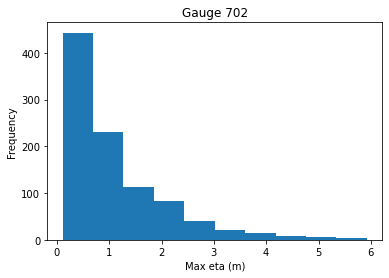

In [15]:
plt.hist(tsr.max_eta(eta,702,runnos))
plt.title('Gauge 702')
plt.xlabel('Max eta (m)')
plt.ylabel('Frequency')

### Filter features

Refer to https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html for more info. (Un)comment relevant block as needed

In [16]:
def filter_features(feat,gmax, c_or_r):
    """
    Filters the features using the select_features function from the tsfresh library.
    Input:
        feat - List of feature dataframes
        gmax - Target values that the features are compared against (max eta for a gauge in this case).
        c_or_r - Character denoting machine learning task of interest (classification of regression)
    Output:
        filtered - List of filtered feature dataframes.
    """
    
    if c_or_r == 'c':
        type = 'classification'
    elif c_or_r == 'r':
        type = 'regression'
    else:
        raise Exception("Invalid input")
    
    filtered = []
    for i in range(len(feat)):
            filtered.append(select_features(feat[i],gmax,ml_task=type))
    return filtered

In [17]:
# Filter features

feat702_filt901 = filter_features(feat702, g901max, 'r')
feat702_filt911 = filter_features(feat702, g911max, 'r')

params_30min_901_f = settings.from_columns(feat702_filt901[0])
params_60min_901_f = settings.from_columns(feat702_filt901[1])
params_30min_911_f = settings.from_columns(feat702_filt911[0])
params_60min_911_f = settings.from_columns(feat702_filt911[1])

## Build and Test Model

In [18]:
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import clone
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, accuracy_score

from matplotlib.lines import Line2D

In [19]:
# Import the run numbers and indices for test/train sets
runnos_train = np.loadtxt(os.path.join(path,'data\sjdf_train_runno.txt')).astype(int)
runnos_test = np.loadtxt(os.path.join(path,'data\sjdf_test_runno.txt')).astype(int)
index_train = np.loadtxt(os.path.join(path,'data\sjdf_train_index.txt')).astype(int)
index_test = np.loadtxt(os.path.join(path,'data\sjdf_test_index.txt')).astype(int)

### Regression

In [20]:
# Choice of model. comment/uncomment as needed

rmodel = GridSearchCV(SVR(kernel='rbf', gamma='scale', cache_size=1000), param_grid={"C": [1e-2,5e-1,1e0, 1e1, 5e1, 1e2],
                                                                   "gamma": np.logspace(-5, 0, 21)})
# rmodel =  RandomForestRegressor(n_estimators=100)
# rmodel = GradientBoostingRegressor(loss='ls')
# rmodel = DecisionTreeRegressor()

### Train and Test Models

In [21]:
sc = True

## Gauge 901
# Unfiltered
pred_901, trp_901, target_901, evs_901, scalers_901, models_901 = tsr.train_test(feat702, g901max, runnos, index_train, index_test,
                                                                              sc,'r', rmodel,True)

# Filtered
# pred_901_f, trp_901_f, target_901_f, evs_901_f, scalers_901_f, models_901_f = tsr.train_test(feat702_filt901, g901max, runnos, 
#                                                                     index_train, index_test, sc,'r', rmodel, True)

## Gauge 911
# Unfiltered
pred_911, trp_911, target_911, evs_911, scalers_911, models_911 = tsr.train_test(feat702, g911max, runnos, index_train, index_test, 
                                                                                  sc, 'r', rmodel, True)

# Filtered
# pred_911_f, trp_911_f, target_911_f, evs_911_f, scalers_911_f, models_911_f = tsr.train_test(feat702_filt911, g911max, runnos, 
#                                                                 index_train, index_test, sc, 'r', rmodel, True)

In [22]:
# print model parameters, (Un)comment as needed

# print(models_901[0].best_params_)
# print(models_901[1].best_params_)
# print(models_901_f[0].best_params_)
# print(models_901_f[1].best_params_)
# print()
# print(models_911[0].best_params_)
# print(models_911[1].best_params_)
# print(models_911_f[0].best_params_)
# print(models_911_f[1].best_params_)

In [23]:
# print EVS score, (Un)comment as needed

# np.vstack((evs_901,evs_901_f,evs_911,evs_911_f))

# Verify models on Real data


In [24]:
def load_verif_test(file, interp):
    gdata = np.loadtxt(file)
    
    t_tmp   = gdata[:,1] 
    eta_tmp = gdata[:,5]
    
    tt = np.arange(0., t_tmp[-1], interp)
    
    gaugefcn = interp1d(t_tmp , eta_tmp, kind='linear', bounds_error=False)
    eta_unif = gaugefcn(tt)
    
    return eta_unif, tt

In [25]:
def verif_max_eta(outdir, gaugeno):
    gdata = np.loadtxt(os.path.join(outdir, 'gauge%s.txt' % str(gaugeno).zfill(5)))
    
    return np.amax(gdata[:,5])

In [26]:
def feat_verif_test(eta_u, tt_u, tstep, params):
    dict_tmp = {'id':np.ones(len(eta_u[0:tstep])), 'time':tt_u[0:tstep], 'eta': eta_u[0:tstep]}
    feat_tmp = extract_features(pd.DataFrame(dict_tmp), column_id='id', column_sort='time', 
                                   kind_to_fc_parameters=params) 
    
    return feat_tmp

### 1700 Event
Data not generated with the K-L expansion idea and is supposed to be a model for the event of January 26, 1700

### Load and Interp Data

In [27]:
file1700 = r'C:\Users\Chris\Documents\Tsunami\jdf-autoencoder\python\data\wang1700\gauge00702.txt'

eta_unif_1700, tt702_1700 = load_verif_test(file1700, 10)
   
# set a value of 0 to the first data point since it is NaN due to interp. This fails when I don't capture that initial drop
eta_unif_1700[0]=0 

#### Plot gauge

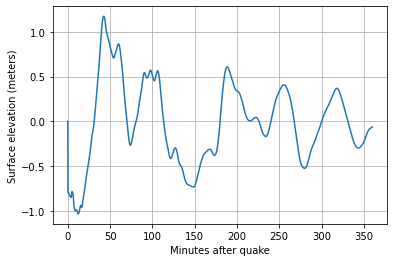

In [28]:
plot(tt702_1700/60, eta_unif_1700)

xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

In [29]:
# Featurize
feat_702_1700 = [feat_verif_test(eta_unif_1700, tt702_1700, 181, params_30min), 
                 feat_verif_test(eta_unif_1700, tt702_1700, 361, params_60min)]

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


In [30]:
# Predict
#featurized
pred_1700_901 = tsr.predict(scalers_901,models_901,feat_702_1700)
pred_1700_911 = tsr.predict(scalers_911,models_911,feat_702_1700)

#raw this doesnt havent enough data so I had to just add an extra value to the end.
# pred_1700_901 = tsr.predict(scalers_901,models_901,[eta_unif_1700[0:181].reshape(1, -1), eta_unif_1700[0:361].reshape(1, -1)])
# pred_1700_911 = tsr.predict(scalers_911,models_911,[eta_unif_1700[0:181].reshape(1, -1), eta_unif_1700[0:361].reshape(1, -1)])

Actual

Gauge 702: max eta = 1.173, Gauge 901: max eta = 2.927, Gauge 911: max eta = 0.946

In [31]:
np.vstack((pred_1700_901,pred_1700_911))

array([[3.60067786, 2.96592657],
       [1.53825049, 1.20825393]])

## B-Whole

Whole-length CSZ rupture with a buried fault. See [Gao et al](https://link.springer.com/article/10.1007%2Fs11069-018-3397-6).

In [32]:
filebwhole = r'C:\Users\Chris\Desktop\Tsunami Personal\B-Whole_gauges\gauge00702.txt'

eta_unif_bw, tt702_bw = load_verif_test(filebwhole, 10)
   
# set a value of 0 to the first data point since it is NaN due to interp. This fails when I don't capture that initial drop
eta_unif_bw[0]=0 

In [33]:
filedir = r'C:\Users\Chris\Desktop\Tsunami Personal\B-Whole_gauges'

print(verif_max_eta(filedir, 901))
print(verif_max_eta(filedir, 911))

4.249535
1.671745


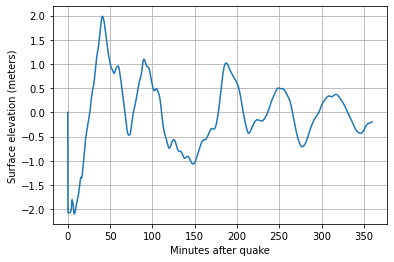

In [34]:
plot(tt702_bw/60, eta_unif_bw)

xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

In [35]:
feat_702_bw = [feat_verif_test(eta_unif_bw, tt702_bw, 181, params_30min),
                 feat_verif_test(eta_unif_bw, tt702_bw, 361, params_60min)]

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


In [36]:
# Predict
# Featurized
pred_bw_901 = tsr.predict(scalers_901,models_901,feat_702_bw)
pred_bw_911 = tsr.predict(scalers_911,models_911,feat_702_bw)


# Raw
# pred_bw_901 = tsr.predict(scalers_901,models_901,[eta_unif_bw[0:181].reshape(1, -1), eta_unif_bw[0:361].reshape(1, -1)])
# pred_bw_911 = tsr.predict(scalers_911,models_911,[eta_unif_bw[0:181].reshape(1, -1), eta_unif_bw[0:361].reshape(1, -1)])

np.vstack((pred_bw_901,pred_bw_911))

array([[5.4090731 , 4.56775249],
       [2.62633617, 2.12470789]])

## S-A-Whole

Whole-length CSZ rupture with a buried fault, has splay faults. See [Gao et al](https://link.springer.com/article/10.1007%2Fs11069-018-3397-6).

In [37]:
filesawhole = r'C:\Users\Chris\Desktop\Tsunami Personal\S-A-Whole_gauges\gauge00702.txt'

eta_unif_sa, tt702_sa = load_verif_test(filesawhole, 10)
   
# set a value of 0 to the first data point since it is NaN due to interp. This fails when I don't capture that initial drop
eta_unif_sa[0]=0 

In [38]:
filedir = r'C:\Users\Chris\Desktop\Tsunami Personal\S-A-Whole_gauges'

print(verif_max_eta(filedir, 901))
print(verif_max_eta(filedir, 911))

5.172153
1.911478


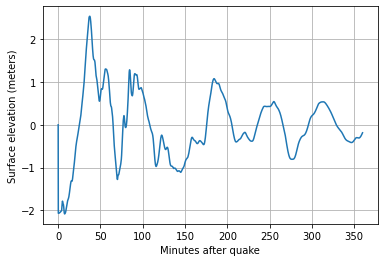

In [39]:
plot(tt702_sa/60, eta_unif_sa)

xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

In [40]:
feat_702_sa = [feat_verif_test(eta_unif_sa, tt702_sa, 180, params_30min), 
                 feat_verif_test(eta_unif_sa, tt702_sa, 360, params_60min)]

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


In [41]:
# Predict
# Featurized
pred_sa_901 = tsr.predict(scalers_901,models_901,feat_702_sa)
pred_sa_911 = tsr.predict(scalers_911,models_911,feat_702_sa)

# Raw
# pred_sa_901 = tsr.predict(scalers_901,models_901,[eta_unif_sa[0:181].reshape(1, -1), eta_unif_sa[0:361].reshape(1, -1)])
# pred_sa_911 = tsr.predict(scalers_911,models_911,[eta_unif_sa[0:181].reshape(1, -1), eta_unif_sa[0:361].reshape(1, -1)])

np.vstack((pred_sa_901,pred_sa_911))

array([[5.42663091, 5.23892636],
       [2.61868924, 2.47463665]])

## L1

Generated from L1 source used for WA State inundation mapping. Includes splay faults.

In [42]:
filel1 = r'C:\Users\Chris\Desktop\Tsunami Personal\L1_gauges\gauge00702.txt'

eta_unif_l1, tt702_l1 = load_verif_test(filel1, 10)
   
# set a value of 0 to the first data point since it is NaN due to interp. This fails when I don't capture that initial drop
eta_unif_l1[0]=0 

In [43]:
filedir = r'C:\Users\Chris\Desktop\Tsunami Personal\L1_gauges'

print(verif_max_eta(filedir, 901))
print(verif_max_eta(filedir, 911))

9.771005
3.864635


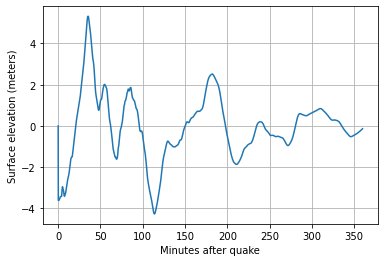

In [44]:
plot(tt702_l1/60, eta_unif_l1)

xlabel('Minutes after quake')
ylabel('Surface elevation (meters)')
grid(True)

In [45]:
feat_702_l1 = [feat_verif_test(eta_unif_l1, tt702_l1, 180, params_30min), 
                 feat_verif_test(eta_unif_l1, tt702_l1, 360, params_60min)]

Feature Extraction: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


In [46]:
# Predict
# Featurized
pred_l1_901 = tsr.predict(scalers_901,models_901,feat_702_l1)
pred_l1_911 = tsr.predict(scalers_911,models_911,feat_702_l1)

# Raw
# pred_l1_901 = tsr.predict(scalers_901,models_901,[eta_unif_l1[0:181].reshape(1, -1), eta_unif_l1[0:361].reshape(1, -1)])
# pred_l1_911 = tsr.predict(scalers_911,models_911,[eta_unif_l1[0:181].reshape(1, -1), eta_unif_l1[0:361].reshape(1, -1)])

np.vstack((pred_l1_901,pred_l1_911))

array([[ 9.28182234, 10.12592717],
       [ 3.77939939,  3.99443378]])

### Plot Results: Regression

In [47]:
plotlabels = ['30 minutes', '60 minutes']

#### 901

Text(0.5, 0.9, 'Gauge 901 (Unfiltered)')

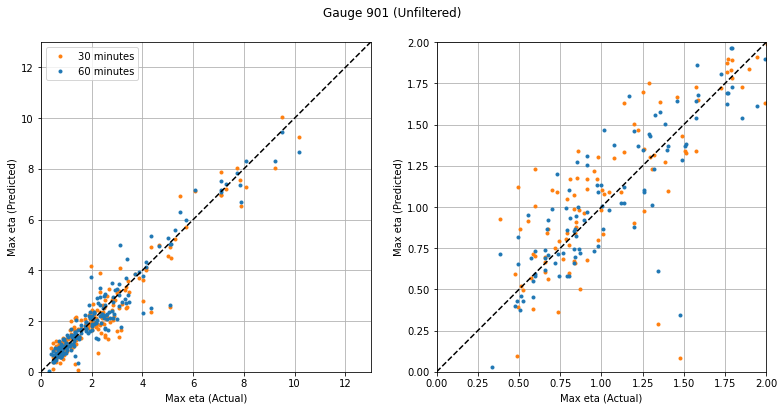

In [48]:
tsr.plot_test_all(target_901,pred_901,13,2, plotlabels)
suptitle('Gauge 901 (Unfiltered)', y = 0.9)
# plt.savefig('g901_gdboost.png')

In [ ]:
tsr.plot_test_all(target_901_f,pred_901_f,13,2, plotlabels)
suptitle('Gauge 901 (Filtered)',y=0.9)
# plt.savefig('g901_f_subs.png')

#### 911

Text(0.5, 0.9, 'Gauge 911 (Unfiltered)')

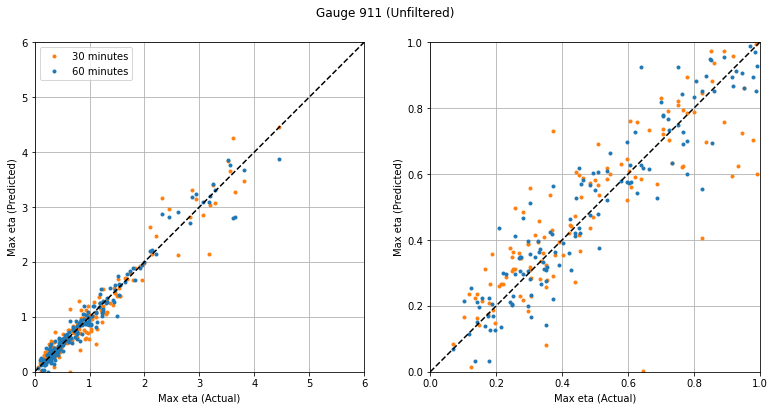

In [50]:
tsr.plot_test_all(target_911,pred_911,6,1, plotlabels)
suptitle('Gauge 911 (Unfiltered)',y=0.9)
# plt.savefig('g911_gdboost.png')

In [ ]:
tsr.plot_test_all(target_911_f,pred_911_f,6,1, plotlabels)
suptitle('Gauge 911 (Filtered)', y=0.9)
# plt.savefig('g911_f_subs.png')

### Output Predictions

In [52]:
#Saving the observed
size = 192
modelname = 'SVRs'

etamax_obs = np.hstack((tsr.max_eta(eta,702,runnos)[index_test].reshape((size,1)), 
    g901max[index_test].reshape((size,1)), g911max[index_test].reshape((size,1))))

np.savetxt('output\etamax_obs_10s.txt', etamax_obs)

etamax_pred_30 = np.hstack((pred_901[0].reshape((size,1)), pred_911[0].reshape((size,1))))
etamax_tr_30 = np.hstack((trp_901[0].reshape((767,1)), trp_911[0].reshape((767,1))))
#etamax_pred_30_f = np.hstack((pred_901_f[0].reshape((size,1)),pred_911_f[0].reshape((size,1))))

np.savetxt('output\etamax_%s_predict_30m.txt' % modelname, etamax_pred_30)
np.savetxt('output\etamax_%s_predict_tr_30m.txt' % modelname, etamax_tr_30)
#np.savetxt('output\etamax_%s_f_predict_30m.txt' % modelname, etamax_pred_30_f)

etamax_pred_60 = np.hstack((pred_901[1].reshape((size,1)),pred_911[1].reshape((size,1))))
etamax_tr_60 = np.hstack((trp_901[1].reshape((767,1)),trp_911[1].reshape((767,1))))
#etamax_pred_60_f = np.hstack((pred_901_f[1].reshape((size,1)),pred_911_f[1].reshape((size,1))))

np.savetxt('output\etamax_%s_predict_60m.txt' % modelname, etamax_pred_60)
np.savetxt('output\etamax_%s_predict_tr_60m.txt' % modelname, etamax_tr_60)
#np.savetxt('output\etamax_%s_f_predict_60m.txt' % modelname, etamax_pred_60_f)

nonkl = np.vstack((pred_1700_901, pred_1700_911, pred_bw_901, pred_bw_911, pred_sa_901, pred_sa_911, pred_l1_901, pred_l1_911))
np.savetxt('output\etamax_%s_predict_nonkl.txt' % modelname, nonkl)

## Plotting Specific Runs

In [108]:
importlib.reload(tsr) # remove after done testing

<module 'tsunami_regress' from 'C:\\Users\\Chris\\Dropbox\\Tsunami Research\\tsunami_regress.py'>

In [120]:
# Naming Scheme for predictions, test targets and runs used for testing AND for filtered and unfiltered
# pred_9XX or pred_9XX_f
# target_9XX or target_9XX_f
# runs_9XX or runs_9XX_f

badruns = tsr.find_inacc_runs(pred_901[0], target_901[0], runnos_test, 5)

In [121]:
badruns

,Run Number,Predicted,Actual,Abs Diff
0,902,2.542179,5.100651,2.558473
1,310,4.186818,1.984269,2.202549
2,1084,2.369100,4.323232,1.954132
3,1208,1.373203,3.073361,1.700158
4,942,3.911087,2.310452,1.600635


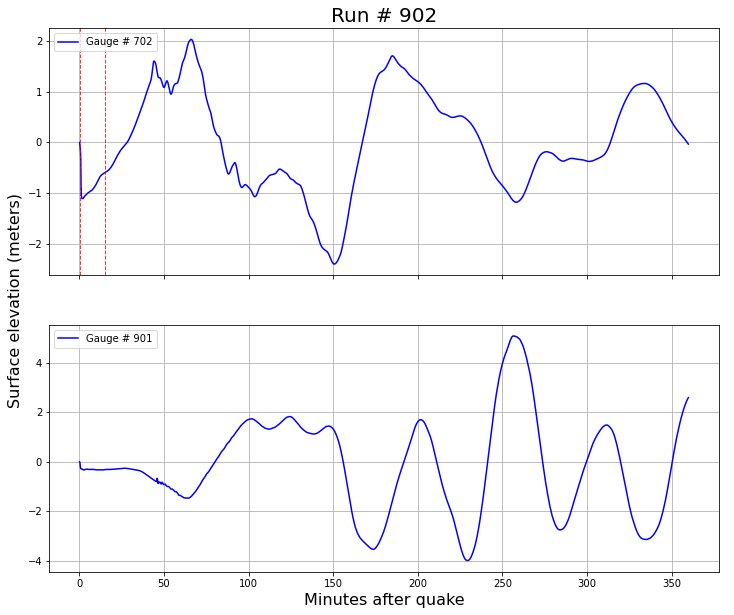

In [122]:
%matplotlib inline

tsr.plot_run(eta, t, tstart, runs_used[0], 902,901,702,0, tsteps,5)
#plt.savefig('r1012_901.png')

In [ ]:
# tsr.find_run(pred_901[0], target_901[0], runs_901[0], 1026)

In [ ]:
#tsr.save_run_plots(eta, t, tstart, runs_used, badruns['Run Number'].tolist(), badruns['Predicted'].tolist(),901,0,tsteps)

#suppress inline output
%matplotlib agg  